The idea here is that the sign of the wave speed should be determined by the sign of the integral of 1-F(m)-m/c in the simple no structure case. This won't be true with all of the juvenile classes, but if we simulate the wave with no structure, we should be able to predict the sign of the wave.

In [5]:
import spatialfunctions as sf
import numpy as np
from scipy import integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [6]:
plt.rcParams['font.family'] = 'serif'

# Make plot colors and things to make it easier to be consistent
#cmap = plt.cm.get_cmap('PiYG')
#cdiscrete = cmap(np.linspace(0, 1, 10))
c0 = 'k'
c1 = plt.cm.get_cmap('Greens').reversed()(0)
c2 = plt.cm.get_cmap('PiYG')(0.15)
c3 = 'tab:olive'

# Figsize consistent
figsize = (3,3)

/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_19973/1318715886.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c1 = plt.cm.get_cmap('Greens').reversed()(0)
/var/folders/l1/prbyqvgx4mg745chvp4d8x3r0000gn/T/ipykernel_19973/1318715886.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c2 = plt.cm.get_cmap('PiYG')(0.15)


In [7]:
# Set params
s = 0.99
N = 60
c = 1300
al= 0.001

# For no structure case
sns = 1#0 # Set this to 0 or 1. 
# 0 means the forest does not regrow after infestation and so the infestation is a pulse.
# 1 means the forest is always at S=1 (this is the more analytically tractable case)

# Use a range of thresholds
plist = np.arange(100,625,25)
plen = len(plist)

# Set up grid to be large enough given the dispersal kernel
xrexp = 19; dx=16;
xr = np.arange(-2**xrexp,2**xrexp+dx,step=dx)

In [10]:
# Do the integral of fopt in the structureless case to look at the sign
intlist = np.zeros(len(plist))
# Also get the speed with and without structure
speed_nostructure = np.zeros(len(plist))
speed_structure = np.zeros(len(plist))
# Also get speed predicted from assuming a caricature allee effect
speed_pred = np.zeros(len(plist))

# How long to simulate for?
nt = 200

# Loop over p
for i,p in enumerate(plist):
    # Simple progress bar
    clear_output(wait=True)
    print(i+1,"/",plen)
    
    # Get fopt
    fopt = sf.getfopt(p,c)

    # First, check to make sure 1-F = m/c exists. 
    # We only need to do this for phi/c > 0.75 (this seems numerically true)
    if p/c>0.75:
        # This returns the value where (1-F)/m is maximized, which we can put in as a bound
        # Or returns an empty array, meaning no solution exists.
        mmax = sf.outbreak_existence(fopt,c)
        if mmax.size>0:
            # If it returns a value, get the initial conditions
            x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N,bracket=[mmax,c+1])
        else:
            # If it is empty, set this array to empty which we will check later
            x0 = np.array([])
            # Integrate to c, but this will be very negative.
            intlist[i] = integrate.quad(lambda x: 1-fopt(x)-x/c,0,c)[0]
            print("Integral doesn't make sense (no positive eq.)")
    # If the params are not that close to 0.75, we can just call this function directly
    else:
        x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N)

    # If after that we have an initial condition to run from, simulate the wave
    # This will be true for both structure and no structure since above we just looked to see if 1-F=m can exist
    if x0.size>0:
        ### INTEGRAL
        intlist[i] = integrate.quad(lambda x: 1-fopt(x)-x/c,0,x0[N+1,0]/x0[N,0])[0]
        
        ### PREDICTION
        # Predicted from caricature Allee effect
        mallee = opt.root_scalar(lambda x: x/c - 1 + fopt(x),bracket=[0.01,3*c/4]).root
        speed_pred[i]=-np.log(2*mallee/c)/al # From Lutscher 6.10 with al=sqrt(2/sigma^2)
        
        ### STRUCTURE
        wave_s = sf.iterate(xr,nt,fopt,x0,al,c,s,N,dx=dx)

        # Find the argument where the first transient outbreak occurs at x=1
        argmax = sf.outbreak_occurs(wave_s,N,xrexp,dx)

        # Only calculate everything if the outbreak actually occurs
        if (argmax.size>0):
            # Get speed
            # First check if the wave collides with the backward wave, only calculate the speed up to that arg
            argcol = sf.collision_arg(wave_s,N,xrexp,dx)
            speed_structure[i] = sf.getspeed(wave_s,argcol,N,xrexp,dx)
        
        ### NO STRUCTURE
        # Get initial setup
        x0_ns = np.zeros([3,len(xr)])
        # Set all susceptibles to 1
        x0_ns[0].fill(1)
        # Set beetles to c
        x0_ns[1,0:int(2**xrexp/dx)] = c

        # Iterate
        wave_ns = sf.iterate(xr,nt,fopt,x0_ns,al,c,s=sns,N=0,dx=dx) # s was 1 previously, which allows the forest to always persist.
        # Check if it makes sense to get speed
        argmax_ns = sf.outbreak_occurs(wave_ns,0,xrexp,dx,cutoff=0.95)
        # Only calculate everything if the outbreak actually occurs
        if (argmax_ns.size>0):
            # Get speed
            # First check if the wave collides with the backward wave, only calculate the speed up to that arg
            argcol_ns = sf.collision_arg(wave_ns,0,xrexp,dx)
            # If the forest doesn't ever die from being infested, just use the default function
            if sns==1:
                speed_nostructure[i] = sf.getspeed(wave_ns,argcol_ns,0,xrexp,dx)
            # Do the speed calculation from scratch here to account for the s=0 case
            # This error comes because when the forest dies, the threshold is too large, and I don't have that as a passable parameter
            # So I have to do it from scratch with a user defined threshold.
            else:
                # Check if all beetles are ever all below the defined threshold
                leading_args = np.zeros(argcol_ns+1)
                thresh = 2 # Just to test
                for j in np.arange(argcol_ns+1):
                    temp = np.where(wave_ns[j,1,int((2**xrexp-2**(xrexp-1))/dx):int((2**xrexp+2**(xrexp-1))/dx)]>thresh/2)[0]
                    # Only add to leading_args if temp is nonzero, ie. wave exists.
                    if temp.size>0:
                        leading_args[j] = temp[-1]
                # Only sum from argcol_ns//2 to where leading_args=0
                thresh_tmax = np.where(leading_args==0)[0]
                # If thresh_tmax has size 0 then the leading args is never zero and we can calculate
                if (thresh_tmax.size==0):
                    speed_nostructure[i] = np.mean(np.gradient(leading_args[argcol_ns//2::]))*dx
                # Alternatively, if the size>0, then we can calculate up to the first time it is zero as long as it is greater
                elif  (thresh_tmax[0]>argcol_ns//2):
                    speed_nostructure[i] = np.mean(np.gradient(leading_args[argcol_ns//2:thresh_tmax[0]]))*dx

21 / 21


# s=0
I resolved the problems and it turns out the speed reduction is basically 100% because of s=0, not the structure at all. I need to rewrite the manuscript reflecting this -- specifically I need to discuss how without any tree mortality it spreads faster, which makes a lot of sense, but isn't what I currently have written!

Text(0, 0.5, 'Speed (km/year)')

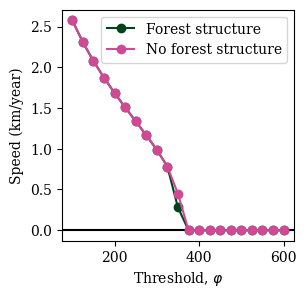

In [74]:
# Plot speeds
plt.figure(figsize=figsize)
plt.plot(plist,speed_structure/1000,'o-',c=c1,label='Forest structure')
plt.plot(plist,speed_nostructure/1000,'o-',c=c2,label='No forest structure')
#plt.plot(plist,speed_pred/1000,'-',c=c3,label='Caricature Allee')
plt.axhline(0,c=c0,zorder=-99)
plt.legend(loc='upper right')
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel('Speed (km/year)')

# s=1
This is the relevant case to relate to the other math papers

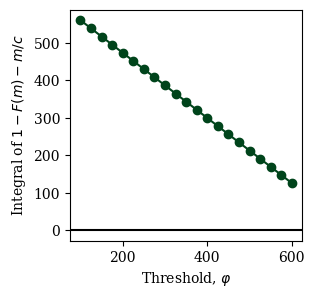

In [11]:
# Plot integral
plt.figure(figsize=figsize)
plt.plot(plist,intlist,'o-',c=c1)
plt.axhline(0,c=c0,zorder=-99)
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel(r'Integral of $1-F(m)-m/c$')
plt.savefig('figures/speed_integral.pdf',bbox_inches='tight')

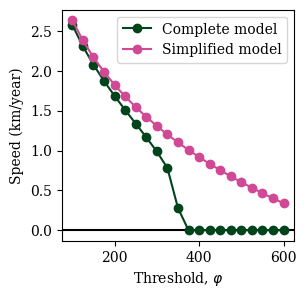

In [12]:
# Plot speeds
plt.figure(figsize=figsize)
plt.plot(plist,speed_structure/1000,'o-',c=c1,label='Complete model')
plt.plot(plist,speed_nostructure/1000,'o-',c=c2,label='Simplified model')
#plt.plot(plist,speed_pred/1000,'-',c=c3,label='Caricature Allee')
plt.axhline(0,c=c0,zorder=-99)
plt.legend(loc='upper right')
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel('Speed (km/year)')
plt.savefig('figures/speed_nosize.pdf',bbox_inches='tight')

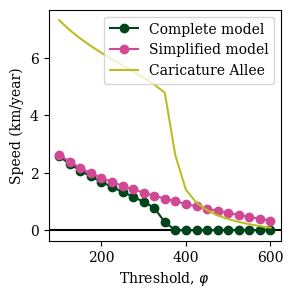

In [13]:
# Plot speeds
plt.figure(figsize=figsize)
plt.plot(plist,speed_structure/1000,'o-',c=c1,label='Complete model')
plt.plot(plist,speed_nostructure/1000,'o-',c=c2,label='Simplified model')
plt.plot(plist,speed_pred/1000,'-',c=c3,label='Caricature Allee')
plt.axhline(0,c=c0,zorder=-99)
plt.legend(loc='upper right')
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel('Speed (km/year)')
plt.savefig('figures/speed_nosize_car.pdf',bbox_inches='tight')

# Numerical check on speed calculation

In [15]:
# Double check this is correct
def fcar(m,mallee):
    fret = np.ones(len(m))
    fret[m>=mallee]=0
    return fret
# Also get speed predicted from assuming a caricature allee effect
speed_pred_num = np.zeros(len(plist))

# Loop over p
for i,p in enumerate(plist):
    # Simple progress bar
    clear_output(wait=True)
    print(i+1,"/",plen)

    # Get mallee
    # Get fopt
    fopt = sf.getfopt(p,c)
    mallee = opt.root_scalar(lambda x: x/c - 1 + fopt(x),bracket=[0.01,3*c/4]).root
    print(mallee)
    
    # Get initial setup
    x0_ns = np.zeros([3,len(xr)])
    # Set all susceptibles to 1
    x0_ns[0].fill(1)
    # Set beetles to c for < 0
    x0_ns[1,0:int(2**xrexp/dx)] = c

    ### STRUCTURE
    wave_pred_num = sf.iterate(xr,nt,fcar,x0_ns,al,c,s,0,dx=dx,mallee=mallee)

    # Find the argument where the first transient outbreak occurs at x=1
    argmax = sf.outbreak_occurs(wave_pred_num,0,xrexp,dx,cutoff=0.95)

    # Only calculate everything if the outbreak actually occurs
    if (argmax.size>0):
        # Get speed
        # First check if the wave collides with the backward wave, only calculate the speed up to that arg
        argcol = sf.collision_arg(wave_pred_num,0,xrexp,dx)
        speed_pred_num[i] = sf.getspeed(wave_pred_num,argcol,0,xrexp,dx)

# The error message here corresponds to when the solution is negative, 
# which makes sense given how I'm calculating the speed

20 / 21
563.3290238474605


IndexError: index -1 is out of bounds for axis 0 with size 0

Text(0, 0.5, 'Speed (km/year)')

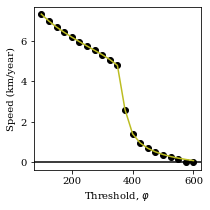

In [16]:
# Compare numerical and analytic
plt.figure(figsize=figsize)
plt.plot(plist,speed_pred_num/1000,'o',c=c0,label='Cariculate Allee (num)')
plt.plot(plist,speed_pred/1000,'-',c=c3,label='Caricature Allee')
plt.axhline(0,c=c0,zorder=-99)
#plt.legend(loc='upper right')
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel('Speed (km/year)')

Text(0, 0.5, '1-F(m)')

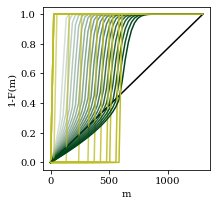

In [17]:
# Also plot function for comparison
plt.figure(figsize=figsize)

# Get mrange to plot
mr = np.linspace(0,c)
# Loop over p
for i,p in enumerate(plist):
    # Get fopt
    fopt = sf.getfopt(p,c)
    mallee = opt.root_scalar(lambda x: x/c - 1 + fopt(x),bracket=[0.01,3*c/4]).root
    
    # Plot fopt
    plt.plot(mr,1-fopt(mr),c=c1,alpha=p/plist[-1],label=r'Full F, $\varphi = {:.0f}$'.format(p))
    # fcar
    plt.plot(mr,1-fcar(mr,mallee),c=c3,alpha=p/plist[-1],label='Caricature')
# 1:1 line
plt.plot(mr,mr/c,c='k',zorder=-99)
# plt.legend() # No legend since there is a plot for so many p
plt.xlabel('m')
plt.ylabel('1-F(m)')

# Force wave turnaround
Try for a few very high values of phi just to check if the wave does turn araound

In [14]:
plist_extend = np.arange(625,825,25)
# Do the integral of fopt in the structureless case to look at the sign
intlist_extend = np.zeros(len(plist_extend))
# Also get the speed with and without structure
speed_nostructure_extend = np.zeros(len(plist_extend))
speed_structure_extend = np.zeros(len(plist_extend))
# Also get speed predicted from assuming a caricature allee effect
speed_pred_extend = np.zeros(len(plist_extend))

# Loop over p
for i,p in enumerate(plist_extend):
    # Simple progress bar
    clear_output(wait=True)
    print(i+1,"/",len(plist_extend))
    
    # Get fopt
    fopt = sf.getfopt(p,c)

    # First, check to make sure 1-F = m/c exists. 
    # We only need to do this for phi/c > 0.75 (this seems numerically true)
    if p/c>0.75:
        # This returns the value where (1-F)/m is maximized, which we can put in as a bound
        # Or returns an empty array, meaning no solution exists.
        mmax = sf.outbreak_existence(fopt,c)
        if mmax.size>0:
            # If it returns a value, get the initial conditions
            x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N,bracket=[mmax,c+1])
        else:
            # If it is empty, set this array to empty which we will check later
            x0 = np.array([])
            # Integrate to c, but this will be very negative.
            intlist[i] = integrate.quad(lambda x: 1-fopt(x)-x/c,0,c)[0]
            print("Integral doesn't make sense (no positive eq.)")
    # If the params are not that close to 0.75, we can just call this function directly
    else:
        x0 = sf.get_x0even(xrexp,dx,fopt,c,s,N)

    # If after that we have an initial condition to run from, simulate the wave
    # This will be true for both structure and no structure since above we just looked to see if 1-F=m can exist
    if x0.size>0:
        ### INTEGRAL
        intlist_extend[i] = integrate.quad(lambda x: 1-fopt(x)-x/c,0,x0[N+1,0]/x0[N,0])[0]
        
        ### PREDICTION
        # Predicted from caricature Allee effect
        mallee = opt.root_scalar(lambda x: x/c - 1 + fopt(x),bracket=[0.01,0.9*c]).root
        speed_pred_extend[i]=-np.log(2*mallee/c)/al # From Lutscher 6.10 with al=sqrt(2/sigma^2)
        
        ### STRUCTURE
        wave_s = sf.iterate(xr,nt,fopt,x0,al,c,s,N,dx=dx)

        # Find the argument where the first transient outbreak occurs at x=1
        argmax = sf.outbreak_occurs(wave_s,N,xrexp,dx)

        # Calculate speed regardless
        speed_structure_extend[i] = sf.getspeed(wave_s,nt,N,xrexp,dx)
        
        ### NO STRUCTURE
        # Get initial setup
        x0_ns = np.zeros([3,len(xr)])
        # Set all susceptibles to 1
        x0_ns[0].fill(1)
        # Set beetles to c
        x0_ns[1,0:int(2**xrexp/dx)] = c

        # Iterate
        wave_ns = sf.iterate(xr,nt,fopt,x0_ns,al,c,s=sns,N=0,dx=dx)
        # Get speed regardless
        speed_nostructure_extend[i] = sf.getspeed(wave_ns,nt,0,xrexp,dx)

8 / 8


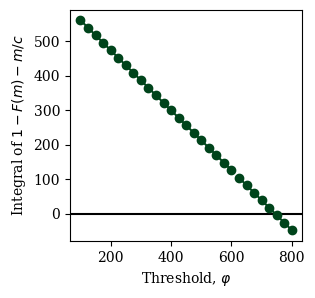

In [17]:
# Plot integral
plt.figure(figsize=figsize)
plt.plot(plist,intlist,'o-',c=c1)
plt.plot(plist_extend,intlist_extend,'o-',c=c1)
plt.axhline(0,c=c0,zorder=-99)
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel(r'Integral of $1-F(m)-m/c$')
#plt.ylim(-80,280)
plt.savefig('figures/speed_integral_extend.pdf',bbox_inches='tight')

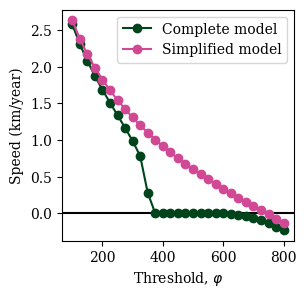

In [18]:
# Plot speeds
plt.figure(figsize=figsize)
plt.plot(plist,speed_structure/1000,'o-',c=c1,label='Complete model')
plt.plot(plist_extend,speed_structure_extend/1000,'o-',c=c1)
plt.plot(plist,speed_nostructure/1000,'o-',c=c2,label='Simplified model')
plt.plot(plist_extend,speed_nostructure_extend/1000,'o-',c=c2)
plt.axhline(0,c=c0,zorder=-99)
plt.legend(loc='upper right')
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel('Speed (km/year)')
plt.savefig('figures/speed_nosize_extend.pdf',bbox_inches='tight')

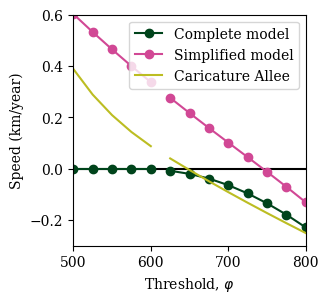

In [19]:
# Plot speeds
plt.figure(figsize=figsize)
plt.plot(plist,speed_structure/1000,'o-',c=c1,label='Complete model')
plt.plot(plist_extend,speed_structure_extend/1000,'o-',c=c1)
plt.plot(plist,speed_nostructure/1000,'o-',c=c2,label='Simplified model')
plt.plot(plist_extend,speed_nostructure_extend/1000,'o-',c=c2)
plt.plot(plist,speed_pred/1000,'-',c=c3,label='Caricature Allee')
plt.plot(plist_extend,speed_pred_extend/1000,'-',c=c3)
plt.axhline(0,c=c0,zorder=-99)
plt.legend(loc='upper right')
plt.xlabel(r'Threshold, $\varphi$')
plt.ylabel('Speed (km/year)')
plt.ylim(-0.3,0.6)
plt.xlim(500,800)
plt.savefig('figures/speed_nosize_car_extend.pdf',bbox_inches='tight')

In [25]:
# Check the reversal there is actually true
p = 625

# Get fopt
fopt = sf.getfopt(p,c)

### STRUCTURE
wave_s = sf.iterate(xr,nt,fopt,x0,al,c,s,N,dx=dx)

(-10.0, 10.0)

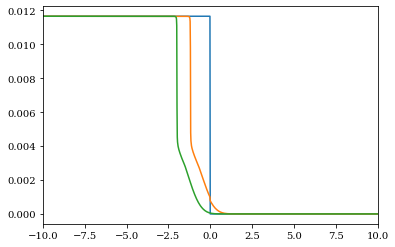

In [30]:
plt.plot(xr/1000,wave_s[0,N+2])
plt.plot(xr/1000,wave_s[100,N+2])
plt.plot(xr/1000,wave_s[-1,N+2])
plt.xlim(-10,10)